# preparation 1: import module.

In [1]:
import os

import matplotlib.pyplot as plt

import scipy.signal as sig
import numpy as np
import scipy.io.wavfile as scw

import wave
import cmath as cm

import math

speech_sample_dir = 'speech_sample'

# preparation 2: read a wave file.
read signal data from a wav file without using any library.

speech_sample/A_a.wav
RIFF identifier b'RIFF'
Chunk size 3950
format b'WAVE'
fmt identifier b'fmt '
Number of bytes in fmt chunk 16
Audio format 1
Number of channels 1
Sampling rate 16000
Average number of bytes per second 32000
Block size 2
Bit / sample 16
Sub chunk identifier b'data'
Sub chunk size 3914


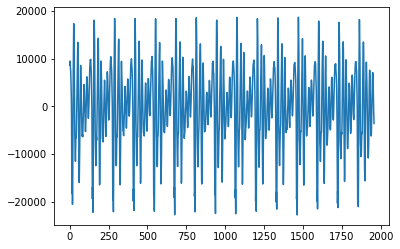

In [2]:
wav_file = os.path.join(speech_sample_dir, 'A_a.wav')
print(wav_file)

with open(wav_file, mode='rb') as f:
    content = f.read()

print("RIFF identifier " + str(content[0:4]))
print("Chunk size " + str(int.from_bytes(content[4:8], "little")))
print("format " + str(content[8:12]))
print("fmt identifier " + str(content[12:16]))
print("Number of bytes in fmt chunk " + str(int.from_bytes(content[16:20], "little")))
print("Audio format " + str(int.from_bytes(content[20:22], "little")))
print("Number of channels " + str(int.from_bytes(content[22:24], "little")))
print("Sampling rate " + str(int.from_bytes(content[24:28], "little")))
print("Average number of bytes per second " + str(int.from_bytes(content[28:32], "little")))
print("Block size " + str(int.from_bytes(content[32:34], "little")))
print("Bit / sample " + str(int.from_bytes(content[34:36], "little")))
print("Sub chunk identifier " + str(content[36:40]))
print("Sub chunk size " + str(int.from_bytes(content[40:44], "little")))

data = []
for i in range(0, int(len(content[44:])), 2):
    s1 = content[44 + i]
    s2 = content[44 + i + 1]
    left_b = s2 << 8
    right_b = s1
    s = (left_b | right_b)
    if s > 32767:
        s = s - 65536
    data.append(s)

# numpy array of wave data 
np_wave_data = np.array(data)
plt.plot(np_wave_data)
plt.show()


# preparation 3: Correlation function definition

In [3]:
# dt: wave data
# N: Window size
# max_m: Maximum number of samples to shift

# Autocorrelation function
# r(m) = sum( x(n)*x(n+m) ) n=0~N-m-1, m=0~N-1
def auto_correlate(dt):
    
    cor = sig.correlate(dt,dt,mode="full")
    return cor[cor.size//2:]

# Cross-correlation function
def correlate(dt):
    return sig.correlate(dt[:N+max_m],dt[:N],mode="valid")

# first peak analyze
def calc_first_peak_index(array):
    i = 0
    while array[i] > array[i+1]:
        i += 1
    while array[i] < array[i+1]:
        i += 1
    return i

# Correlation function
def calc_correlate(ts1, ts2, nlags=512):
    ts1, ts2 = np.asarray(ts1), np.asarray(ts2)
    nlags += 1
    N      = min(len(ts1),len(ts2))
    nts1   = ((ts1-ts1.mean())/ts1.std())[:N]
    nts2   = ((ts2-ts2.mean())/ts2.std())[:N]
    nlags  = min(N,nlags)
    result = [(nts1*nts2).sum()/N]
    for lag in range(1,nlags):
        result.append((nts1[lag:]*nts2[:-lag]).sum()/N)
    return np.asarray(result)


# task1: Calculation of autocorrelation coefficient

23
695.6521739130435 512


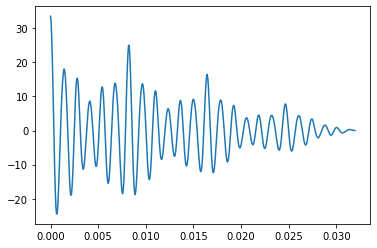

23
695.6521739130435 512


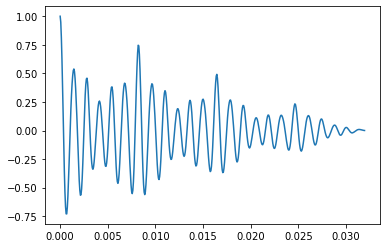

In [4]:
# sampling rate
fs = int.from_bytes(content[24:28], "little")
ts = 1 / fs
dt = np_wave_data / (2 ** 15) # numpy array of wave data / 32768

# calulate target parameter
win_size = 2 ** 9 # 512
start = 0

# Calculation of autocorrelation coefficient by library
cor = auto_correlate(dt[start : start + win_size])
peak_index = calc_first_peak_index(cor)
print(peak_index)
freq = 1 / (peak_index * ts)
print(freq, cor.size)

plt.plot(np.arange(cor.size) * ts, cor)
plt.show()

# Calculation of autocorrelation coefficient by script
cor_ori = calc_correlate(dt[start : start + win_size], dt[start : start + win_size], nlags=512)
peak_index_ori = calc_first_peak_index(cor_ori)
print(peak_index_ori)
freq_ori = 1 / (peak_index_ori * ts)
print(freq_ori, cor_ori.size)

plt.plot(np.arange(cor_ori.size) * ts, cor_ori)
plt.show()

# preparation 4: DFT and FFT definition

In [5]:
def DFT(data):
    res = []
    N = len(data)
    for k in range(N): #各周波数に関して
        w = cm.exp(-1j * 2 * cm.pi * k / float(N))
        X_k = 0
        for n in range(N): #信号*重みの総和をとる
            X_k += data[n] * (w ** n)
        res.append(abs(X_k))
    return res

def FFT(x):
    N = x.shape[0]
    
    # 再起動作の一番最後
    if N==1:
        return x[0]
    
    x_even = x[0:N:2]
    x_odd = x[1:N:2]
    
    # ここで再帰動作をする
    X_even = FFT(x_even)
    X_odd = FFT(x_odd)
    
    # DFTと同じようにWを求める
    W = []
    for t in range(N//2):
        W.append(np.exp(-1j * ((2*np.pi*t) / N)))
    W = np.array(W)
    
    # ここで型をcomplexに指定しないとエラーを吐くので注意
    X = np.zeros(N, dtype="complex")
    X[0:N//2] = X_even + W*X_odd
    X[N//2:N] = X_even - W*X_odd
    
    return X


# task 2-1: Calculation of DFT

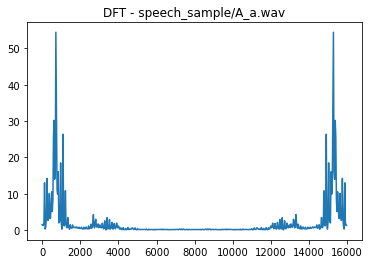

In [6]:
channels = int.from_bytes(content[22:24], "little")
chunk_size = len(content[44:]) // 2
amp  = (2**8) ** int.from_bytes(content[32:34], "little") / 2
wave_data = content[44:]
wave_data = np.frombuffer(wave_data,'int16')
wave_data = wave_data / amp

# Calculation of DFT
dft_data = DFT(wave_data[0:512])

# 周波数リストを作成
# 標本化周波数をデータ数で分割 
frq = np.arange(len(wave_data[0:512])) * fs / len(wave_data[0:512])

# グラフ表示
plt.title("DFT - " + wav_file)
plt.plot(frq,dft_data)

# グラフ表示
plt.show()


# task 2-2: Calculation of FFT

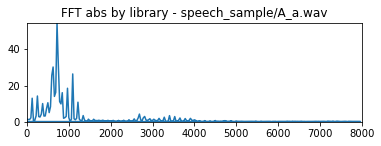

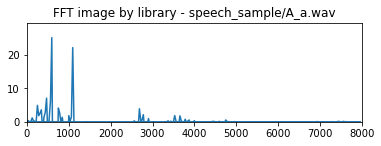

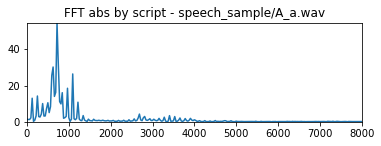

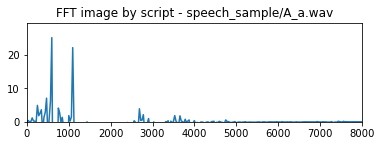

In [7]:
d = 1.0 / fs
size = 512
# Calculation of FFT by library
fft_data = np.fft.fft(wave_data[0:0 + size])
frq = np.fft.fftfreq(size,d)

plt.subplot(2,1,1)
plt.title("FFT abs by library - " + wav_file)
plt.plot(frq,abs(fft_data))
plt.axis([0,fs/2,0,max(abs(fft_data))])

plt.show()

plt.subplot(2,1,2)
plt.title("FFT image by library - " + wav_file)
plt.plot(frq,np.imag(fft_data))
plt.axis([0,fs/2,0,max(np.imag(fft_data))])

plt.show()

# Calculation of FFT by script
fft_data_ori = FFT(wave_data[0:0 + size])
freq_ori = np.arange(len(fft_data_ori)) * fs / len(fft_data_ori)

plt.subplot(2,1,1)
plt.title("FFT abs by script - " + wav_file)
plt.plot(freq_ori,abs(np.array(fft_data_ori)))
plt.axis([0,fs/2,0,max(abs(np.array(fft_data_ori)))])

plt.show()

plt.subplot(2,1,2)
plt.title("FFT image by script - " + wav_file)
plt.plot(freq_ori,np.imag(np.array(fft_data_ori)))
plt.axis([0,fs/2,0,max(np.imag(np.array(fft_data_ori)))])

plt.show()

# preparation 5: Logarithmic power spectrum definition